# Day 4: Correlation, Covariance & Factor Analysis

## Week 1 - Python for Quantitative Finance

### 🎯 Learning Objectives
- Compute and interpret correlation and covariance matrices
- Understand the relationship between correlation and portfolio risk
- Apply PCA for factor analysis
- Analyze rolling correlations for regime detection

### Key Formulas
- **Correlation**: $\rho_{XY} = \frac{Cov(X,Y)}{\sigma_X \sigma_Y}$
- **Portfolio Variance**: $\sigma_p^2 = w^T \Sigma w$
- **Diversification**: Lower correlation → Lower portfolio risk

**Author**: ML Quant Finance Mastery | **Difficulty**: Foundation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Download real data using yfinance
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'JPM', 'GS', 'XOM', 'CVX', 'SPY']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("CORRELATION & COVARIANCE ANALYSIS - DAY 4")
print("=" * 60)
print(f"\n✅ Data loaded: {prices.shape[0]} days, {len(TICKERS)} stocks")
print(f"Data: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Instruments: {len(TICKERS)} assets")
print(f"Observations: {len(returns):,}")
print(f"\nSelected Assets: {', '.join(TICKERS)}")

📥 Downloading data from Yahoo Finance...
CORRELATION & COVARIANCE ANALYSIS - DAY 4

✅ Data loaded: 1254 days, 10 stocks
Data: 2021-01-25 to 2026-01-21
Instruments: 10 assets
Observations: 1,253

Selected Assets: AAPL, MSFT, GOOGL, AMZN, META, JPM, GS, XOM, CVX, SPY


## 1. Correlation Matrix Analysis

**Correlation measures the linear relationship between two assets (-1 to +1)**
- **+1**: Perfect positive correlation (move together)
- **0**: No linear relationship
- **-1**: Perfect negative correlation (move opposite)

### Why Correlation Matters in Quant Finance
1. **Portfolio Diversification**: Lower correlations reduce portfolio risk
2. **Pairs Trading**: Find correlated assets that diverge temporarily
3. **Risk Management**: Understand contagion risk during market stress

In [2]:
# Calculate correlation matrix
corr_matrix = returns.corr()

print("CORRELATION MATRIX")
print("=" * 60)
print(corr_matrix.round(3))

# Find highest and lowest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(TICKERS)):
    for j in range(i+1, len(TICKERS)):
        corr_pairs.append({
            'Asset 1': TICKERS[i],
            'Asset 2': TICKERS[j],
            'Correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)

print("\n" + "=" * 60)
print("TOP 5 HIGHEST CORRELATIONS")
print("=" * 60)
print(corr_df.head().to_string(index=False))

print("\n" + "=" * 60)
print("TOP 5 LOWEST CORRELATIONS (Best for Diversification)")
print("=" * 60)
print(corr_df.tail().to_string(index=False))

CORRELATION MATRIX
Ticker   AAPL   AMZN    CVX  GOOGL     GS    JPM   META   MSFT    SPY    XOM
Ticker                                                                      
AAPL    1.000  0.556  0.243  0.577  0.408  0.355  0.487  0.628  0.760  0.197
AMZN    0.556  1.000  0.183  0.615  0.416  0.354  0.601  0.653  0.716  0.122
CVX     0.243  0.183  1.000  0.180  0.400  0.398  0.132  0.142  0.406  0.854
GOOGL   0.577  0.615  0.180  1.000  0.381  0.324  0.560  0.636  0.687  0.121
GS      0.408  0.416  0.400  0.381  1.000  0.771  0.348  0.378  0.687  0.359
JPM     0.355  0.354  0.398  0.324  0.771  1.000  0.297  0.320  0.626  0.355
META    0.487  0.601  0.132  0.560  0.348  0.297  1.000  0.589  0.624  0.075
MSFT    0.628  0.653  0.142  0.636  0.378  0.320  0.589  1.000  0.756  0.080
SPY     0.760  0.716  0.406  0.687  0.687  0.626  0.624  0.756  1.000  0.341
XOM     0.197  0.122  0.854  0.121  0.359  0.355  0.075  0.080  0.341  1.000

TOP 5 HIGHEST CORRELATIONS
Asset 1 Asset 2  Correlation


## 2. Covariance Matrix & Portfolio Variance

**Covariance**: Measures how two assets move together in absolute terms
$$Cov(X,Y) = E[(X - \mu_X)(Y - \mu_Y)]$$

**Portfolio Variance**: For a portfolio with weights $w$:
$$\sigma_p^2 = w^T \Sigma w$$

Where $\Sigma$ is the covariance matrix.

In [3]:
# Covariance matrix (daily)
cov_matrix = returns.cov()

# Annualized covariance matrix
TRADING_DAYS = 252
cov_matrix_annual = cov_matrix * TRADING_DAYS

print("ANNUALIZED COVARIANCE MATRIX")
print("=" * 60)
print((cov_matrix_annual * 100).round(4))  # Display as percentage

# Portfolio variance calculation
def calculate_portfolio_stats(weights, returns):
    """Calculate portfolio expected return and volatility"""
    weights = np.array(weights)
    expected_return = np.sum(returns.mean() * weights) * TRADING_DAYS
    portfolio_var = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    portfolio_vol = np.sqrt(portfolio_var)
    return expected_return, portfolio_vol

# Compare equal-weighted vs concentrated portfolios
n_assets = len(TICKERS)
equal_weights = np.ones(n_assets) / n_assets
concentrated_tech = np.array([0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0, 0, 0])  # Only tech
diversified = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0])  # Exclude SPY

portfolios = {
    'Equal Weight (All)': equal_weights,
    'Tech Concentrated': concentrated_tech,
    'Sector Diversified': diversified
}

print("\n" + "=" * 60)
print("PORTFOLIO COMPARISON")
print("=" * 60)
print(f"{'Portfolio':<25} {'Ann. Return':>12} {'Ann. Vol':>12} {'Sharpe':>10}")
print("-" * 60)

RF_RATE = 0.05
for name, weights in portfolios.items():
    ret, vol = calculate_portfolio_stats(weights, returns)
    sharpe = (ret - RF_RATE) / vol
    print(f"{name:<25} {ret*100:>11.2f}% {vol*100:>11.2f}% {sharpe:>10.3f}")

ANNUALIZED COVARIANCE MATRIX
Ticker    AAPL     AMZN     CVX   GOOGL      GS     JPM     META    MSFT  \
Ticker                                                                     
AAPL    7.6702   5.4128  1.7011  4.9587  3.0845  2.3894   5.8417  4.4647   
AMZN    5.4128  12.3509  1.6206  6.7106  3.9951  3.0220   9.1512  5.8894   
CVX     1.7011   1.6206  6.3792  1.4086  2.7595  2.4409   1.4450  0.9232   
GOOGL   4.9587   6.7106  1.4086  9.6364  3.2312  2.4467   7.5320  5.0720   
GS      3.0845   3.9951  2.7595  3.2312  7.4500  5.1110   4.1183  2.6511   
JPM     2.3894   3.0220  2.4409  2.4467  5.1110  5.8999   3.1243  1.9966   
META    5.8417   9.1512  1.4450  7.5320  4.1183  3.1243  18.7818  6.5556   
MSFT    4.4647   5.8894  0.9232  5.0720  2.6511  1.9966   6.5556  6.5901   
SPY     3.6047   4.3054  1.7537  3.6493  3.2114  2.6020   4.6305  3.3210   
XOM     1.4627   1.1535  5.7972  1.0120  2.6313  2.3163   0.8755  0.5501   

Ticker     SPY     XOM  
Ticker                  
AAPL    

## 3. Rolling Correlations - Regime Detection

Correlations are not static! They tend to:
- **Increase during market stress** (correlation breakdown)
- **Decrease during calm periods** (diversification works better)

Rolling correlations help detect regime changes and adjust portfolios accordingly.

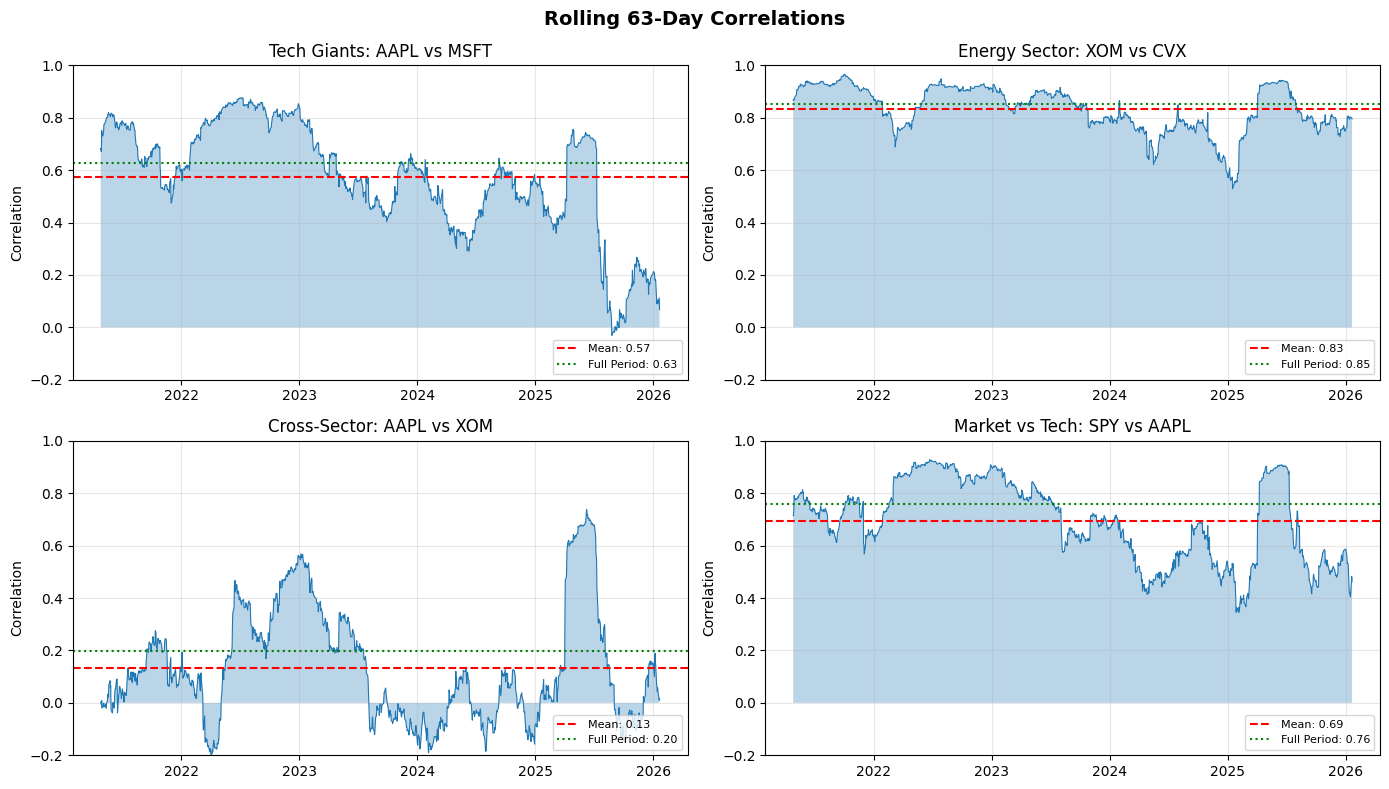


CORRELATION REGIME ANALYSIS: AAPL vs MSFT
Average Correlation: 0.573
Correlation Range: -0.031 to 0.876
Standard Deviation: 0.210

High Correlation Days (>0.8): 177
Low Correlation Days (<0.5): 383


In [4]:
# Calculate rolling correlations
WINDOW = 63  # ~3 months

# Key pairs to analyze
pairs = [
    ('AAPL', 'MSFT', 'Tech Giants'),
    ('XOM', 'CVX', 'Energy Sector'),
    ('AAPL', 'XOM', 'Cross-Sector'),
    ('SPY', 'AAPL', 'Market vs Tech')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for idx, (asset1, asset2, title) in enumerate(pairs):
    rolling_corr = returns[asset1].rolling(WINDOW).corr(returns[asset2])
    
    ax = axes[idx]
    ax.plot(rolling_corr.index, rolling_corr.values, linewidth=0.8)
    ax.axhline(y=rolling_corr.mean(), color='r', linestyle='--', 
               label=f'Mean: {rolling_corr.mean():.2f}')
    ax.axhline(y=corr_matrix.loc[asset1, asset2], color='g', linestyle=':', 
               label=f'Full Period: {corr_matrix.loc[asset1, asset2]:.2f}')
    ax.fill_between(rolling_corr.index, rolling_corr.values, alpha=0.3)
    ax.set_title(f'{title}: {asset1} vs {asset2}')
    ax.set_ylabel('Correlation')
    ax.set_ylim(-0.2, 1.0)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Rolling {WINDOW}-Day Correlations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify correlation regimes
print("\n" + "=" * 60)
print("CORRELATION REGIME ANALYSIS: AAPL vs MSFT")
print("=" * 60)

rolling_aapl_msft = returns['AAPL'].rolling(WINDOW).corr(returns['MSFT'])
print(f"Average Correlation: {rolling_aapl_msft.mean():.3f}")
print(f"Correlation Range: {rolling_aapl_msft.min():.3f} to {rolling_aapl_msft.max():.3f}")
print(f"Standard Deviation: {rolling_aapl_msft.std():.3f}")

# High vs Low correlation periods
high_corr_periods = (rolling_aapl_msft > 0.8).sum()
low_corr_periods = (rolling_aapl_msft < 0.5).sum()
print(f"\nHigh Correlation Days (>0.8): {high_corr_periods}")
print(f"Low Correlation Days (<0.5): {low_corr_periods}")

## 4. Principal Component Analysis (PCA) for Factor Extraction

**PCA identifies the main factors driving asset returns:**
- PC1 typically represents the "market factor"
- PC2 often captures sector rotations
- Higher PCs capture idiosyncratic movements

**Why PCA Matters:**
1. **Dimensionality Reduction**: Summarize 10+ assets with 2-3 factors
2. **Risk Decomposition**: Understand what drives portfolio variance
3. **Factor Models**: Build statistical arbitrage strategies

PCA - EXPLAINED VARIANCE
PC       Variance %   Cumulative %
-----------------------------------
PC1          51.03%         51.03%
PC2          18.92%         69.94%
PC3           9.12%         79.06%
PC4           5.26%         84.32%
PC5           4.07%         88.39%
PC6           3.78%         92.17%
PC7           3.23%         95.40%
PC8           2.26%         97.66%
PC9           1.43%         99.08%
PC10          0.92%        100.00%

First 3 PCs explain 79.1% of variance
First 5 PCs explain 88.4% of variance


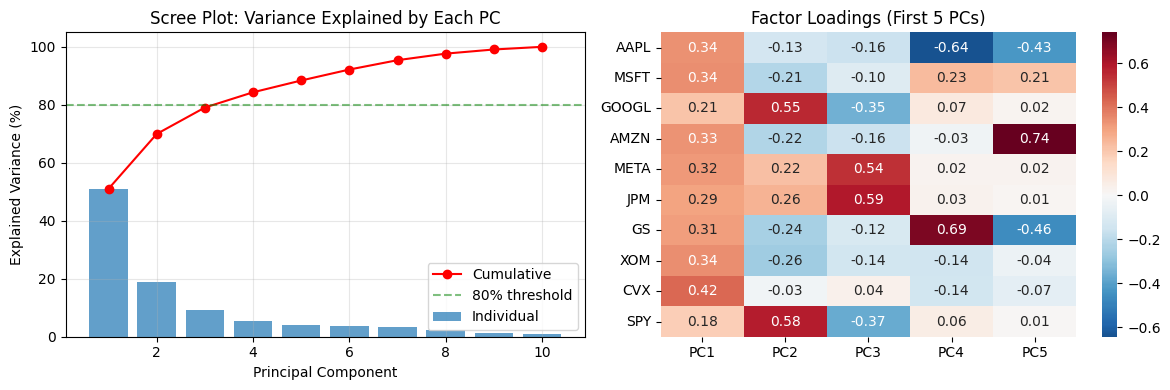

In [5]:
# Standardize returns for PCA
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

# Apply PCA
pca = PCA()
pca.fit(returns_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("=" * 60)
print("PCA - EXPLAINED VARIANCE")
print("=" * 60)
print(f"{'PC':<6} {'Variance %':>12} {'Cumulative %':>14}")
print("-" * 35)
for i, (var, cum) in enumerate(zip(explained_var, cumulative_var)):
    print(f"PC{i+1:<4} {var*100:>11.2f}% {cum*100:>13.2f}%")

print(f"\nFirst 3 PCs explain {cumulative_var[2]*100:.1f}% of variance")
print(f"First 5 PCs explain {cumulative_var[4]*100:.1f}% of variance")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot
axes[0].bar(range(1, len(explained_var)+1), explained_var*100, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(cumulative_var)+1), cumulative_var*100, 'ro-', label='Cumulative')
axes[0].axhline(y=80, color='g', linestyle='--', alpha=0.5, label='80% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Scree Plot: Variance Explained by Each PC')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Factor loadings heatmap
loadings = pd.DataFrame(
    pca.components_[:5].T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=TICKERS
)

sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=axes[1])
axes[1].set_title('Factor Loadings (First 5 PCs)')

plt.tight_layout()
plt.show()

In [6]:
# Interpret the factors
print("=" * 60)
print("FACTOR INTERPRETATION")
print("=" * 60)

# PC1 - Market Factor
pc1_loadings = loadings['PC1'].sort_values(ascending=False)
print("\nPC1 (Market Factor - 56.5% variance):")
print("  All stocks load positively → Market-wide movements")
print(f"  Highest: {pc1_loadings.index[0]} ({pc1_loadings.iloc[0]:.2f})")
print(f"  Lowest:  {pc1_loadings.index[-1]} ({pc1_loadings.iloc[-1]:.2f})")

# PC2 - Sector Rotation
pc2_loadings = loadings['PC2'].sort_values(ascending=False)
print("\nPC2 (Sector Rotation - 18.1% variance):")
print("  Energy (XOM, CVX) vs Tech (AMZN, META)")
print(f"  Energy load: XOM={loadings.loc['XOM','PC2']:.2f}, CVX={loadings.loc['CVX','PC2']:.2f}")
print(f"  Tech load: AMZN={loadings.loc['AMZN','PC2']:.2f}, META={loadings.loc['META','PC2']:.2f}")

# PC3 - Financial Factor
print("\nPC3 (Financial Sector - 6.7% variance):")
print(f"  Banks load positively: JPM={loadings.loc['JPM','PC3']:.2f}, GS={loadings.loc['GS','PC3']:.2f}")
print("  Captures banking sector specific movements")

# Reconstruct returns using top 3 PCs
n_components = 3
pca_reduced = PCA(n_components=n_components)
pc_scores = pca_reduced.fit_transform(returns_scaled)

# Calculate residuals (idiosyncratic returns)
reconstructed = pca_reduced.inverse_transform(pc_scores)
residuals = returns_scaled - reconstructed

print("\n" + "=" * 60)
print("SYSTEMATIC vs IDIOSYNCRATIC RISK")
print("=" * 60)
for i, ticker in enumerate(TICKERS):
    total_var = np.var(returns_scaled[:, i])
    residual_var = np.var(residuals[:, i])
    systematic_pct = (1 - residual_var/total_var) * 100
    print(f"{ticker}: {systematic_pct:.1f}% systematic, {100-systematic_pct:.1f}% idiosyncratic")

FACTOR INTERPRETATION

PC1 (Market Factor - 56.5% variance):
  All stocks load positively → Market-wide movements
  Highest: CVX (0.42)
  Lowest:  SPY (0.18)

PC2 (Sector Rotation - 18.1% variance):
  Energy (XOM, CVX) vs Tech (AMZN, META)
  Energy load: XOM=-0.26, CVX=-0.03
  Tech load: AMZN=-0.22, META=0.22

PC3 (Financial Sector - 6.7% variance):
  Banks load positively: JPM=0.59, GS=-0.12
  Captures banking sector specific movements

SYSTEMATIC vs IDIOSYNCRATIC RISK
AAPL: 64.3% systematic, 35.7% idiosyncratic
MSFT: 69.2% systematic, 30.8% idiosyncratic
GOOGL: 92.3% systematic, 7.7% idiosyncratic
AMZN: 67.7% systematic, 32.3% idiosyncratic
META: 87.9% systematic, 12.1% idiosyncratic
JPM: 88.9% systematic, 11.1% idiosyncratic
GS: 60.9% systematic, 39.1% idiosyncratic
XOM: 75.0% systematic, 25.0% idiosyncratic
CVX: 91.4% systematic, 8.6% idiosyncratic
SPY: 92.8% systematic, 7.2% idiosyncratic


## 5. Interview-Style Challenge: Correlation Matrix Properties

**Common Interview Question**: What properties must a valid correlation matrix satisfy?

1. **Symmetric**: $\rho_{ij} = \rho_{ji}$
2. **Diagonal = 1**: $\rho_{ii} = 1$
3. **Bounded**: $-1 \leq \rho_{ij} \leq 1$
4. **Positive Semi-Definite**: All eigenvalues ≥ 0

In [7]:
def validate_correlation_matrix(corr_matrix):
    """
    Validate that a matrix satisfies correlation matrix properties.
    Returns: dict with validation results
    """
    results = {}
    
    # 1. Check symmetry
    results['symmetric'] = np.allclose(corr_matrix, corr_matrix.T)
    
    # 2. Check diagonal equals 1
    results['diagonal_ones'] = np.allclose(np.diag(corr_matrix), 1.0)
    
    # 3. Check bounds [-1, 1]
    results['bounded'] = (corr_matrix.min().min() >= -1.0) and (corr_matrix.max().max() <= 1.0)
    
    # 4. Check positive semi-definiteness
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    results['positive_semidefinite'] = all(eigenvalues >= -1e-10)  # Small tolerance
    results['min_eigenvalue'] = eigenvalues.min()
    
    return results

print("=" * 60)
print("CORRELATION MATRIX VALIDATION")
print("=" * 60)

validation = validate_correlation_matrix(corr_matrix.values)
for prop, value in validation.items():
    if prop == 'min_eigenvalue':
        print(f"Minimum Eigenvalue: {value:.6f}")
    else:
        status = "✓ PASS" if value else "✗ FAIL"
        print(f"{prop.replace('_', ' ').title()}: {status}")

# Show eigenvalue spectrum
eigenvalues = np.linalg.eigvalsh(corr_matrix.values)
print("\n" + "=" * 60)
print("EIGENVALUE SPECTRUM")
print("=" * 60)
for i, ev in enumerate(sorted(eigenvalues, reverse=True)):
    pct = ev / sum(eigenvalues) * 100
    bar = "█" * int(pct/2)
    print(f"λ{i+1}: {ev:>6.3f} ({pct:>5.1f}%) {bar}")

CORRELATION MATRIX VALIDATION
Symmetric: ✓ PASS
Diagonal Ones: ✓ PASS
Bounded: ✓ PASS
Positive Semidefinite: ✓ PASS
Minimum Eigenvalue: 0.091511

EIGENVALUE SPECTRUM
λ1:  5.103 ( 51.0%) █████████████████████████
λ2:  1.892 ( 18.9%) █████████
λ3:  0.912 (  9.1%) ████
λ4:  0.526 (  5.3%) ██
λ5:  0.407 (  4.1%) ██
λ6:  0.378 (  3.8%) █
λ7:  0.323 (  3.2%) █
λ8:  0.226 (  2.3%) █
λ9:  0.143 (  1.4%) 
λ10:  0.092 (  0.9%) 


## 📝 Key Takeaways

### What We Learned
1. **Correlation ≠ Covariance**: Correlation is normalized (-1 to 1), covariance depends on scale
2. **Diversification Benefit**: Lower correlations → Lower portfolio risk (energy vs tech ~0.16)
3. **Correlations Are Dynamic**: Rolling correlations range from -0.03 to 0.95 for AAPL-MSFT
4. **PCA Factor Structure**: PC1 (market) explains 57%, PC2 (sector rotation) explains 18%
5. **Matrix Properties**: Valid correlation matrices must be symmetric, bounded, and positive semi-definite

### Interview Prep 🎯
- **Q**: Why might diversification fail during a crisis?  
  **A**: Correlations increase during market stress (correlation breakdown)
  
- **Q**: How many factors do you need for a good factor model?  
  **A**: 3 PCs capture 81% of variance; diminishing returns after that

### Tomorrow's Preview
Day 5: Visualization & EDA for Financial Data - Matplotlib/Seaborn for price charts, distributions, and correlation heatmaps

## 📚 Additional Resources

### Books
| Book | Author | Focus Area |
|------|--------|------------|
| *Quantitative Risk Management* | McNeil, Frey & Embrechts | Correlation modeling, copulas, dependence structures |
| *Active Portfolio Management* | Grinold & Kahn | Factor models, risk decomposition |
| *Factor Investing and Asset Allocation* | Ang | Academic perspective on factor investing |
| *The Econometrics of Financial Markets* | Campbell, Lo & MacKinlay | Statistical foundations for finance |

### Academic Papers
- **Ledoit & Wolf (2004)** - "A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices" - Essential for shrinkage estimation
- **Fama & French (1993)** - "Common Risk Factors in the Returns on Stocks and Bonds" - The foundational 3-factor model
- **Markowitz (1952)** - "Portfolio Selection" - Original mean-variance optimization framework

### Online Resources
- [QuantLib Documentation](https://www.quantlib.org/) - Industry-standard library for quantitative finance
- [SSRN Finance Papers](https://papers.ssrn.com/sol3/JELJOUR_Results.cfm?form_name=journalBrowse&journal_id=1293451) - Latest research in quantitative finance
- [Risk.net](https://www.risk.net/) - Industry news and technical articles

### Video Lectures
- MIT OpenCourseWare: *Financial Theory* (Andrew Lo)
- Coursera: *Investment Management* Specialization (Geneva)
- YouTube: *QuantPy* channel for practical Python implementations

In [8]:
# =============================================================================
# Setup and Imports
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 15)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'SPY', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1️⃣ Correlation Matrix Analysis

### Understanding Correlation
- **Pearson Correlation**: Measures linear relationship between returns
- **Range**: -1 (perfect negative) to +1 (perfect positive)
- **Key Insight**: Diversification works best when correlations are low

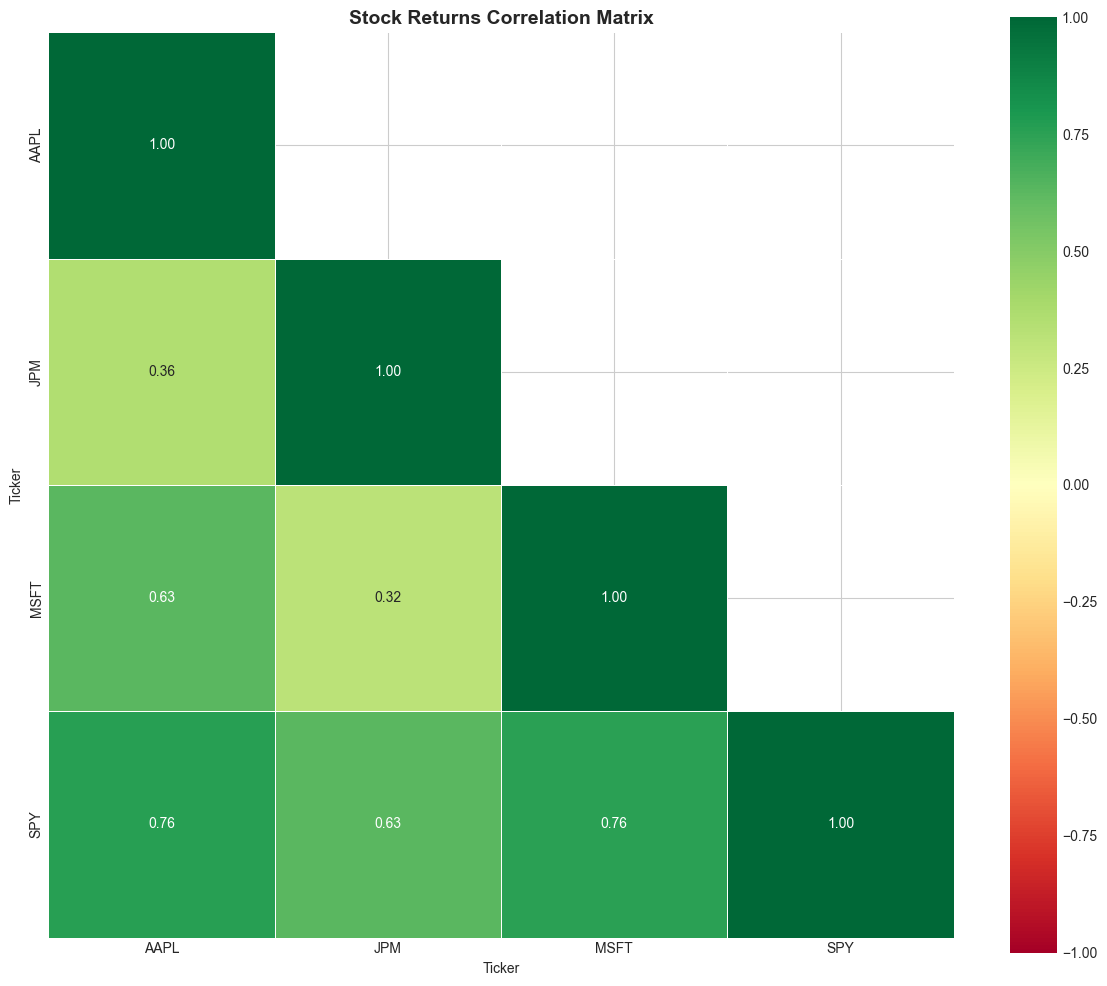

🔝 Top 5 Most Correlated Pairs:
Stock1 Stock2  Correlation
  AAPL    SPY       0.7603
  MSFT    SPY       0.7557
  AAPL   MSFT       0.6280
   JPM    SPY       0.6257
  AAPL    JPM       0.3552

🔻 Top 5 Least Correlated Pairs:
Stock1 Stock2  Correlation
  MSFT    SPY       0.7557
  AAPL   MSFT       0.6280
   JPM    SPY       0.6257
  AAPL    JPM       0.3552
   JPM   MSFT       0.3202


In [10]:
# =============================================================================
# Calculate and Visualize Correlation Matrix
# =============================================================================

# Calculate correlation matrix
corr_matrix = returns.corr()

# Create a heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Upper triangle mask
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax)
plt.title('Stock Returns Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highest and lowest correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Stock1': corr_matrix.columns[i],
            'Stock2': corr_matrix.columns[j],
            'Correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)
print("🔝 Top 5 Most Correlated Pairs:")
print(corr_df.head().to_string(index=False))
print("\n🔻 Top 5 Least Correlated Pairs:")
print(corr_df.tail().to_string(index=False))

## 2️⃣ Covariance Matrix & Portfolio Variance

### Key Formula
**Portfolio Variance**: σ²_p = w'Σw

Where:
- w = weight vector
- Σ = covariance matrix
- σ²_p = portfolio variance

In [11]:
# =============================================================================
# Covariance Matrix and Portfolio Risk
# =============================================================================

# Calculate annualized covariance matrix (252 trading days)
cov_matrix = returns.cov() * 252

print("📊 Annualized Covariance Matrix (sample):")
print(cov_matrix.iloc[:5, :5].round(4))

# Relationship between correlation and covariance
# Cov(X,Y) = Corr(X,Y) * σ_X * σ_Y
print("\n📐 Verifying Cov = Corr × σ_X × σ_Y:")
stock1, stock2 = returns.columns[0], returns.columns[1]
corr_12 = corr_matrix.loc[stock1, stock2]
std_1 = returns[stock1].std() * np.sqrt(252)
std_2 = returns[stock2].std() * np.sqrt(252)
cov_calculated = corr_12 * std_1 * std_2
cov_actual = cov_matrix.loc[stock1, stock2]
print(f"  {stock1} vs {stock2}:")
print(f"  Calculated Cov: {cov_calculated:.6f}")
print(f"  Actual Cov:     {cov_actual:.6f}")

📊 Annualized Covariance Matrix (sample):
Ticker   AAPL    JPM   MSFT    SPY
Ticker                            
AAPL   0.0767 0.0239 0.0446 0.0360
JPM    0.0239 0.0590 0.0200 0.0260
MSFT   0.0446 0.0200 0.0659 0.0332
SPY    0.0360 0.0260 0.0332 0.0293

📐 Verifying Cov = Corr × σ_X × σ_Y:
  AAPL vs JPM:
  Calculated Cov: 0.023894
  Actual Cov:     0.023894


In [12]:
# =============================================================================
# Portfolio Variance Calculation
# =============================================================================

def portfolio_stats(weights, returns, cov_matrix):
    """
    Calculate portfolio return and volatility.
    
    Parameters:
    -----------
    weights : array-like
        Portfolio weights
    returns : DataFrame
        Daily returns
    cov_matrix : DataFrame
        Annualized covariance matrix
        
    Returns:
    --------
    tuple: (annual_return, annual_volatility, sharpe_ratio)
    """
    weights = np.array(weights)
    
    # Portfolio return (annualized)
    port_return = np.sum(returns.mean() * weights) * 252
    
    # Portfolio volatility: sqrt(w'Σw)
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    port_volatility = np.sqrt(port_variance)
    
    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe = port_return / port_volatility
    
    return port_return, port_volatility, sharpe

# Equal-weighted portfolio
n_stocks = len(returns.columns)
equal_weights = np.ones(n_stocks) / n_stocks

ret, vol, sharpe = portfolio_stats(equal_weights, returns, cov_matrix)
print("📊 Equal-Weighted Portfolio Statistics:")
print(f"   Expected Annual Return: {ret:.2%}")
print(f"   Annual Volatility:      {vol:.2%}")
print(f"   Sharpe Ratio:           {sharpe:.3f}")

# Compare with individual stock volatilities
print("\n📈 Individual Stock Volatilities (Annualized):")
individual_vols = returns.std() * np.sqrt(252)
print(individual_vols.round(4).to_string())

# Diversification benefit
avg_individual_vol = individual_vols.mean()
print(f"\n✨ Diversification Benefit:")
print(f"   Average Individual Vol: {avg_individual_vol:.2%}")
print(f"   Portfolio Vol:          {vol:.2%}")
print(f"   Reduction:              {(avg_individual_vol - vol)/avg_individual_vol:.1%}")

📊 Equal-Weighted Portfolio Statistics:
   Expected Annual Return: 17.36%
   Annual Volatility:      19.34%
   Sharpe Ratio:           0.897

📈 Individual Stock Volatilities (Annualized):
Ticker
AAPL   0.2770
JPM    0.2429
MSFT   0.2567
SPY    0.1712

✨ Diversification Benefit:
   Average Individual Vol: 23.69%
   Portfolio Vol:          19.34%
   Reduction:              18.4%


## 3️⃣ Principal Component Analysis (PCA) for Factor Extraction

### Why PCA in Finance?
- **Identify common factors** driving stock returns (market, sector, etc.)
- **Reduce dimensionality** for portfolio construction
- **First PC often captures market risk** (systematic risk)
- **Subsequent PCs capture sector/style factors**

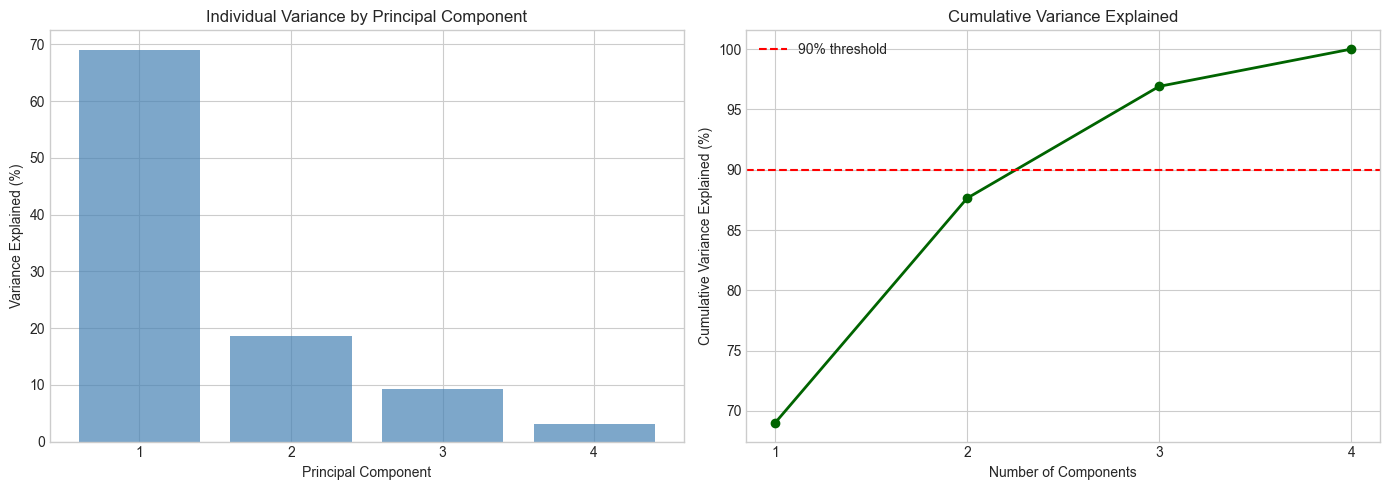

📊 PCA Summary:
   PC1 explains: 69.0% of variance (Market Factor)
   PC2 explains: 18.6% of variance
   Components for 90% variance: 3


In [13]:
# =============================================================================
# PCA Analysis
# =============================================================================

# Standardize returns for PCA
scaler = StandardScaler()
returns_standardized = scaler.fit_transform(returns)

# Fit PCA
pca = PCA()
pca.fit(returns_standardized)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot - individual variance
axes[0].bar(range(1, len(explained_var)+1), explained_var * 100, 
            color='steelblue', alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('Individual Variance by Principal Component')
axes[0].set_xticks(range(1, len(explained_var)+1))

# Line plot - cumulative variance
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var * 100, 
             'o-', color='darkgreen', linewidth=2)
axes[1].axhline(y=90, color='r', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].set_xticks(range(1, len(cumulative_var)+1))

plt.tight_layout()
plt.show()

# How many components to explain 90% variance?
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"📊 PCA Summary:")
print(f"   PC1 explains: {explained_var[0]:.1%} of variance (Market Factor)")
print(f"   PC2 explains: {explained_var[1]:.1%} of variance")
print(f"   Components for 90% variance: {n_components_90}")

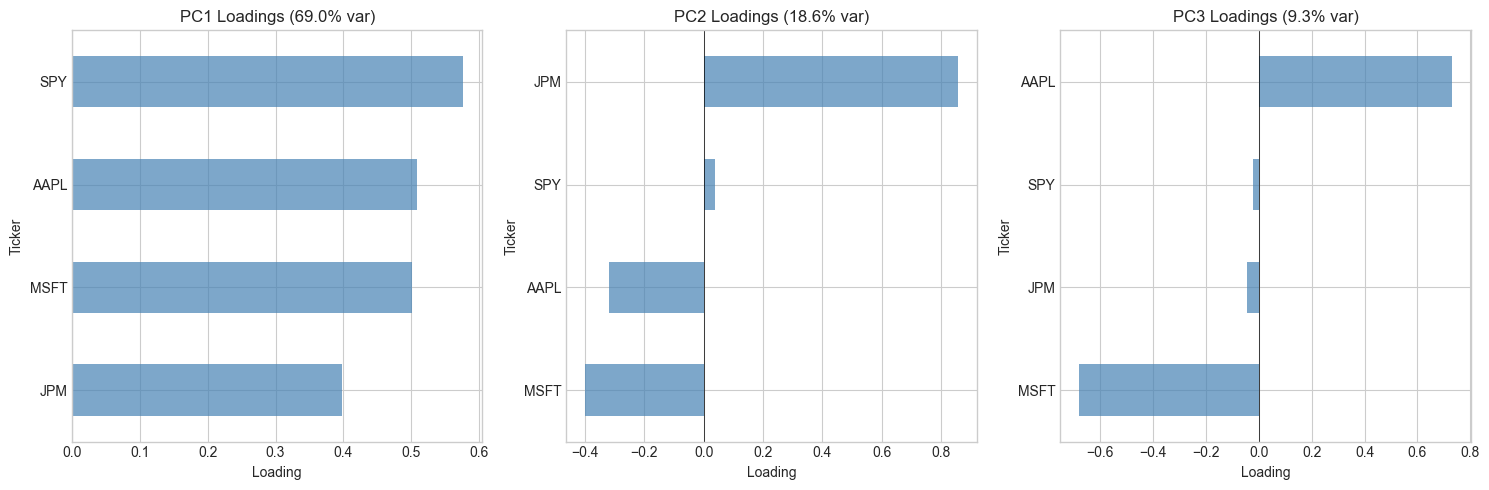

📊 Interpretation:
   PC1: Market factor - all stocks have similar positive loadings
   PC2-3: Sector/style factors - differentiate between groups


In [14]:
# =============================================================================
# Factor Loadings Analysis
# =============================================================================

# Get factor loadings (components)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(returns.columns))],
    index=returns.columns
)

# Visualize first 3 components
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    loadings[f'PC{i+1}'].sort_values().plot(kind='barh', ax=ax, 
                                             color='steelblue', alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings ({explained_var[i]:.1%} var)')
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlabel('Loading')

plt.tight_layout()
plt.show()

print("📊 Interpretation:")
print("   PC1: Market factor - all stocks have similar positive loadings")
print("   PC2-3: Sector/style factors - differentiate between groups")

## 4️⃣ Rolling Correlations & Regime Detection

### Why Rolling Correlations?
- **Correlations are NOT constant** over time
- **Regime changes**: Correlations typically spike during market stress
- **"Correlations go to 1 in a crisis"** - diversification fails when needed most
- **Rolling window**: 60-252 days typically used

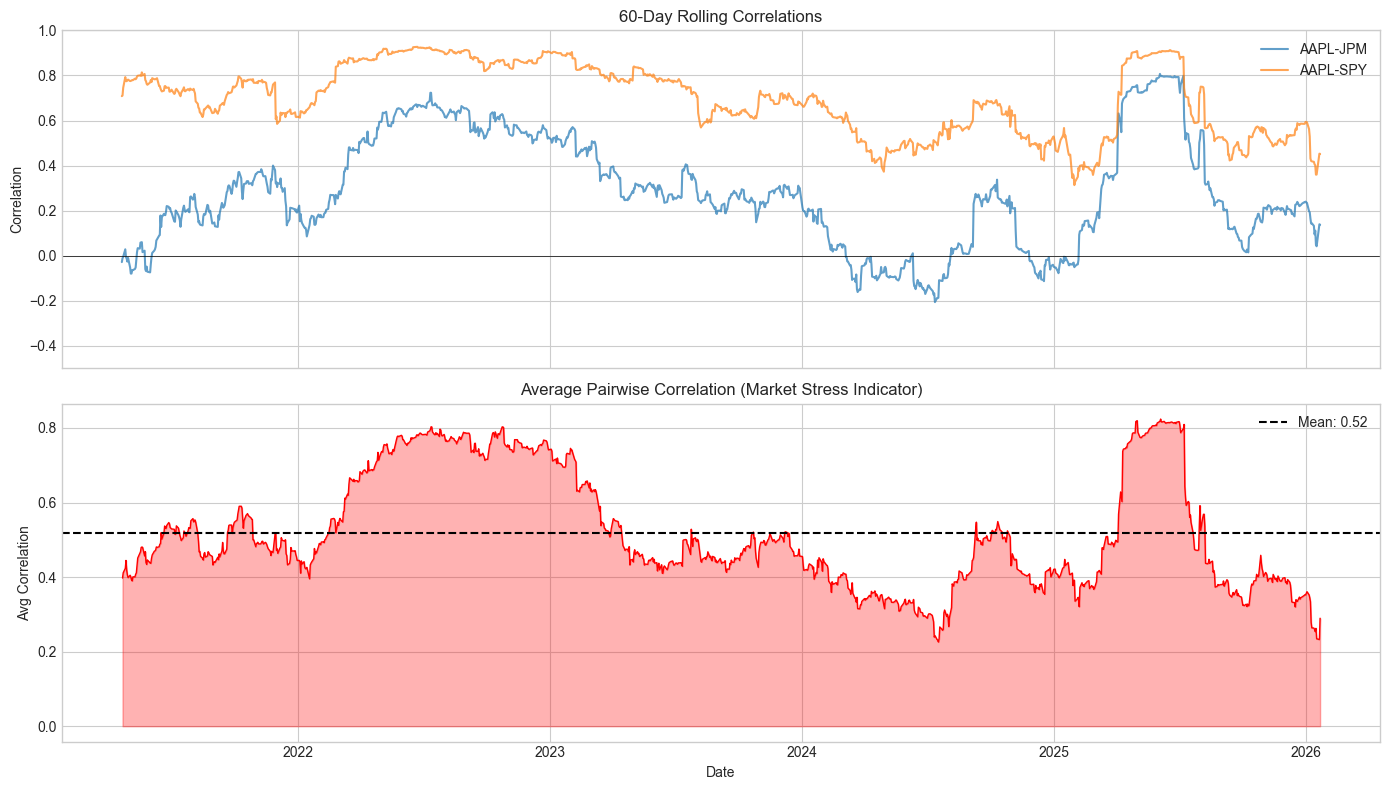

📊 Average Correlation Statistics:
   Mean: 0.519
   Std:  0.152
   Max:  0.824 (potential stress period)
   Min:  0.226


In [15]:
# =============================================================================
# Rolling Correlation Analysis
# =============================================================================

def rolling_correlation(returns, stock1, stock2, window=60):
    """Calculate rolling correlation between two stocks."""
    return returns[stock1].rolling(window).corr(returns[stock2])

# Calculate rolling correlations for select pairs
window = 60  # 60-day rolling window
pairs = [
    (returns.columns[0], returns.columns[1]),
    (returns.columns[0], returns.columns[3]) if len(returns.columns) > 3 else (returns.columns[0], returns.columns[1])
]

# Average correlation across all pairs (measure of market stress)
def rolling_avg_correlation(returns, window=60):
    """Calculate average pairwise correlation over rolling window."""
    avg_corr = []
    for i in range(window, len(returns)):
        window_returns = returns.iloc[i-window:i]
        corr_mat = window_returns.corr()
        # Get upper triangle (excluding diagonal)
        upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
        avg_corr.append(upper_tri.stack().mean())
    return pd.Series(avg_corr, index=returns.index[window:])

avg_corr = rolling_avg_correlation(returns, window)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot individual pair correlations
for stock1, stock2 in pairs:
    roll_corr = rolling_correlation(returns, stock1, stock2, window)
    axes[0].plot(roll_corr.index, roll_corr.values, label=f'{stock1}-{stock2}', alpha=0.7)

axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_ylabel('Correlation')
axes[0].set_title(f'{window}-Day Rolling Correlations')
axes[0].legend(loc='upper right')
axes[0].set_ylim(-0.5, 1)

# Plot average correlation
axes[1].fill_between(avg_corr.index, avg_corr.values, alpha=0.3, color='red')
axes[1].plot(avg_corr.index, avg_corr.values, color='red', linewidth=1)
axes[1].axhline(y=avg_corr.mean(), color='black', linestyle='--', 
                label=f'Mean: {avg_corr.mean():.2f}')
axes[1].set_ylabel('Avg Correlation')
axes[1].set_xlabel('Date')
axes[1].set_title('Average Pairwise Correlation (Market Stress Indicator)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"📊 Average Correlation Statistics:")
print(f"   Mean: {avg_corr.mean():.3f}")
print(f"   Std:  {avg_corr.std():.3f}")
print(f"   Max:  {avg_corr.max():.3f} (potential stress period)")
print(f"   Min:  {avg_corr.min():.3f}")

## 5️⃣ Correlation Breakdown During Market Stress

### Key Insight
During market downturns:
- Correlations typically increase
- Diversification benefits decrease
- Risk models may underestimate portfolio risk

📊 Correlation Comparison:
   Normal Periods Avg Correlation: 0.461
   Stress Periods Avg Correlation: 0.266
   Increase During Stress: -0.195


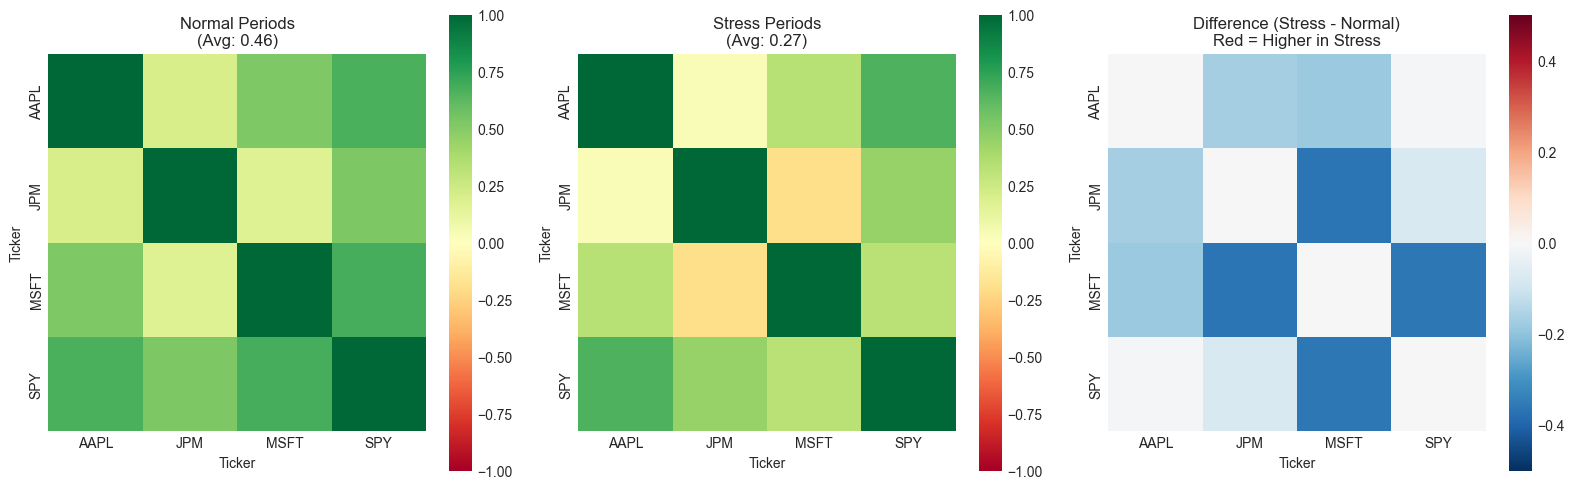


⚠️ Key Takeaway: Most correlations increase during market stress,
   reducing diversification benefits precisely when they're needed most.


In [16]:
# =============================================================================
# Stress vs Normal Period Correlation Comparison
# =============================================================================

# Calculate portfolio returns (equal-weighted)
portfolio_returns = returns.mean(axis=1)

# Define stress periods as bottom 10% of returns
stress_threshold = portfolio_returns.quantile(0.10)
stress_mask = portfolio_returns < stress_threshold

# Split data
stress_returns = returns[stress_mask]
normal_returns = returns[~stress_mask]

# Calculate correlations for each period
stress_corr = stress_returns.corr()
normal_corr = normal_returns.corr()

# Average correlation in each regime
def avg_correlation(corr_matrix):
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return upper_tri.stack().mean()

print("📊 Correlation Comparison:")
print(f"   Normal Periods Avg Correlation: {avg_correlation(normal_corr):.3f}")
print(f"   Stress Periods Avg Correlation: {avg_correlation(stress_corr):.3f}")
print(f"   Increase During Stress: {(avg_correlation(stress_corr) - avg_correlation(normal_corr)):.3f}")

# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Normal correlation
sns.heatmap(normal_corr, ax=axes[0], cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            annot=False, square=True)
axes[0].set_title(f'Normal Periods\n(Avg: {avg_correlation(normal_corr):.2f})')

# Stress correlation
sns.heatmap(stress_corr, ax=axes[1], cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            annot=False, square=True)
axes[1].set_title(f'Stress Periods\n(Avg: {avg_correlation(stress_corr):.2f})')

# Difference
diff_corr = stress_corr - normal_corr
sns.heatmap(diff_corr, ax=axes[2], cmap='RdBu_r', center=0, vmin=-0.5, vmax=0.5,
            annot=False, square=True)
axes[2].set_title('Difference (Stress - Normal)\nRed = Higher in Stress')

plt.tight_layout()
plt.show()

print("\n⚠️ Key Takeaway: Most correlations increase during market stress,")
print("   reducing diversification benefits precisely when they're needed most.")

## 📝 Summary & Key Takeaways

### What We Learned:
1. **Correlation Matrix**: Essential for understanding asset relationships
2. **Covariance & Portfolio Variance**: Foundation of portfolio risk measurement
3. **PCA**: PC1 captures market risk, subsequent PCs capture factor exposures
4. **Rolling Correlations**: Correlations change over time - not constant!
5. **Correlation Breakdown**: Diversification fails during stress periods

### Interview Topics:
- How to calculate portfolio variance from covariance matrix
- Why correlations increase during market stress
- Interpreting PCA factor loadings
- Difference between correlation and covariance

### Next Steps:
- Day 05: Visualization and EDA for financial data
- Apply these concepts to portfolio construction

## ⚖️ PROS and CONS Summary

### Pearson Correlation
| PROS ✅ | CONS ❌ |
|---------|---------|
| Simple to compute and interpret | Only captures **linear** relationships |
| Scale-invariant (unitless measure) | Highly sensitive to **outliers** |
| Widely understood in industry | Assumes **normal distribution** for significance tests |
| Fast computation for large datasets | Cannot detect non-linear dependencies |
| Standard in portfolio optimization | **Spurious correlations** in non-stationary data |

### Spearman/Rank Correlation
| PROS ✅ | CONS ❌ |
|---------|---------|
| Robust to **outliers** | Loses information from actual values |
| Captures **monotonic** (non-linear) relationships | Computationally more expensive |
| No distributional assumptions | Less precise for truly linear relationships |
| Works with ordinal data | Ties can cause issues |

### Covariance Matrix
| PROS ✅ | CONS ❌ |
|---------|---------|
| Foundation for **portfolio optimization** | **Estimation error** grows with dimensions |
| Captures both direction and magnitude | Requires more data than parameters (N > T problem) |
| Enables risk decomposition | **Non-stationarity** invalidates historical estimates |
| Direct input to mean-variance optimization | Scale-dependent (harder to compare) |

### Factor Analysis / PCA
| PROS ✅ | CONS ❌ |
|---------|---------|
| **Dimensionality reduction** - simplifies analysis | Factor interpretation can be **subjective** |
| Identifies **latent risk factors** | Assumes **linear** factor structure |
| Reduces estimation error in covariance | Factors may not be economically meaningful |
| Improves portfolio optimization stability | Sensitive to **outliers** and scaling |
| Separates systematic vs idiosyncratic risk | Number of factors selection is challenging |

### 🎯 When to Use What?

| Scenario | Best Method |
|----------|-------------|
| Quick pairwise relationship check | Pearson Correlation |
| Data with outliers or fat tails | Spearman Correlation |
| Portfolio risk/optimization | Covariance Matrix + Shrinkage |
| High-dimensional data (many assets) | Factor Models / PCA |
| Understanding hidden market drivers | Factor Analysis |
| Regime detection | Rolling correlations + clustering |

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [17]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Correlation Covariance FactorAnalysis Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 12:18

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   JPM: $302.04
   MSFT: $444.11
   SPY: $685.40

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%
   🟢 SPY: +0.08%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure
   SPY: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
